In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from matplotlib.offsetbox import AnchoredText

# Data Visualizations
## Data

In [482]:
conn = psycopg2.connect("dbname=nhl_db")

In [483]:
teams = ['COL', 'TBL', 'TOR', 'MTL', 'OTT', 'BUF']
# teams = ['NJD', 'OTT', 'DET', 'ANA', 'ARI', 'BUF']

In [484]:
cur = conn.cursor()

In [485]:
cur.execute(f"""
    SELECT
        team,
        season,
        game_date,
        win as wins,
        loss as losses,
        ot_loss as ot_losses,
        goals_for,
        goals_against
    FROM summary
    WHERE playoffs = FALSE
    AND season >= '2012/13'
""", teams)

In [486]:
rows = cur.fetchall()

In [487]:
df = pd.DataFrame(data=rows, columns=[entry[0] for entry in cur.description])  

In [488]:
df.head()

,team,season,game_date,wins,losses,ot_losses,goals_for,goals_against
0,BOS,2021/22,2022-03-12,1,0,0,3,2
1,BOS,2021/22,2022-01-08,1,0,0,5,2
2,OTT,2021/22,2021-12-11,1,0,0,4,0
3,OTT,2021/22,2022-04-29,1,0,0,4,2
4,OTT,2021/22,2021-10-29,1,0,0,4,1


In [489]:
df.game_date = pd.to_datetime(df.game_date)
df["games_played"] = 1

In [490]:
cur.close()
conn.close()

In [491]:
season_df = df.groupby(['season', 'team'])[['wins', 'losses', 'ot_losses', 'goals_for', 'goals_against', 'games_played']].sum().reset_index()

In [437]:
season_df.head()

,season,team,wins,losses,ot_losses,goals_for,goals_against,games_played
0,2012/13,ANA,30,12,6,134,115,48
1,2012/13,ARI,21,18,9,121,125,48
2,2012/13,BOS,28,14,6,127,106,48
3,2012/13,BUF,21,21,6,118,139,48
4,2012/13,CAR,19,25,4,127,159,48


In [438]:
season_df.wins = season_df.wins + 0.5 * season_df.ot_losses
season_df.head()

,season,team,wins,losses,ot_losses,goals_for,goals_against,games_played
0,2012/13,ANA,33.0,12,6,134,115,48
1,2012/13,ARI,25.5,18,9,121,125,48
2,2012/13,BOS,31.0,14,6,127,106,48
3,2012/13,BUF,24.0,21,6,118,139,48
4,2012/13,CAR,21.0,25,4,127,159,48


## Winning Percentage

In [439]:
def WinPercentageBySeason():
    season_df["winpc"] = 100 * season_df["wins"] / season_df["games_played"]
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    
    fig.suptitle("Regular Season Winning Percentages\n(by team)")
    fig.supylabel("Win Percentage")
    
    fig.subplots_adjust(top=.92)
    
    positionIndex = 0
    
    for team in teams:
        columnIndex = positionIndex % 2
        rowIndex = positionIndex // 2
        
        xs = season_df.loc[(season_df.team == team), "season"]
        ys = season_df.loc[(season_df.team == team), "winpc"]
        
        axes = axs[rowIndex][columnIndex]
        
        axes.set_ylim([20, 80])
        
        axes.set_title(team.upper())
        
        axes.plot([0.28, 0.72], [0.28, 0.72], 'k-', alpha=0.75, zorder=1, linewidth=0.3)
        axes.plot(xs, ys, linewidth=2)
        
        for other_team in season_df.team.unique():
            if (other_team != team):
                xs = season_df.loc[(season_df.team == other_team), "season"]
                ys = season_df.loc[(season_df.team == other_team), "winpc"]
                
                axes.plot(xs, ys, linewidth=1, alpha=.3, color="grey")
        
        
        positionIndex += 1
    
    plt.savefig('winning_percentage.png')

In [440]:
# WinPercentageBySeason()

In [479]:
def GoalScoredAndAllowed():
    season_df["gf_avg"] = season_df["goals_for"] / season_df["games_played"]
    season_df["ga_avg"] = season_df["goals_against"] / season_df["games_played"]
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 18))
    
    fig.suptitle("Goals per Game\n(by team)")
    fig.subplots_adjust(top=.92)
    
    positionIndex = 0
    
    for team in teams:
        xs = season_df.loc[season_df.team == team, "gf_avg"]
        ys = season_df.loc[season_df.team == team, "ga_avg"]
        color = season_df.loc[season_df.team == team, "season"]
        
        rowIndex = positionIndex // 2
        columnIndex = positionIndex % 2
        axes = axs[rowIndex][columnIndex]
        
        axes.set_xlim([1.5, 4.5])
        axes.set_ylim([1.5, 4.5])
        
        axes.scatter(xs, ys)
        axes.plot([1.5, 4.5], [1.5, 4.5], 'k-', alpha=0.75, zorder=1, linewidth=0.3)
        positionIndex+=1
        
        axes.set_title(f"{team}")
        axes.set_xlabel("Goals Scored per Game")
        axes.set_ylabel("Goals Allowed per Game")
    
    plt.savefig('goals_scored_allowed.png')

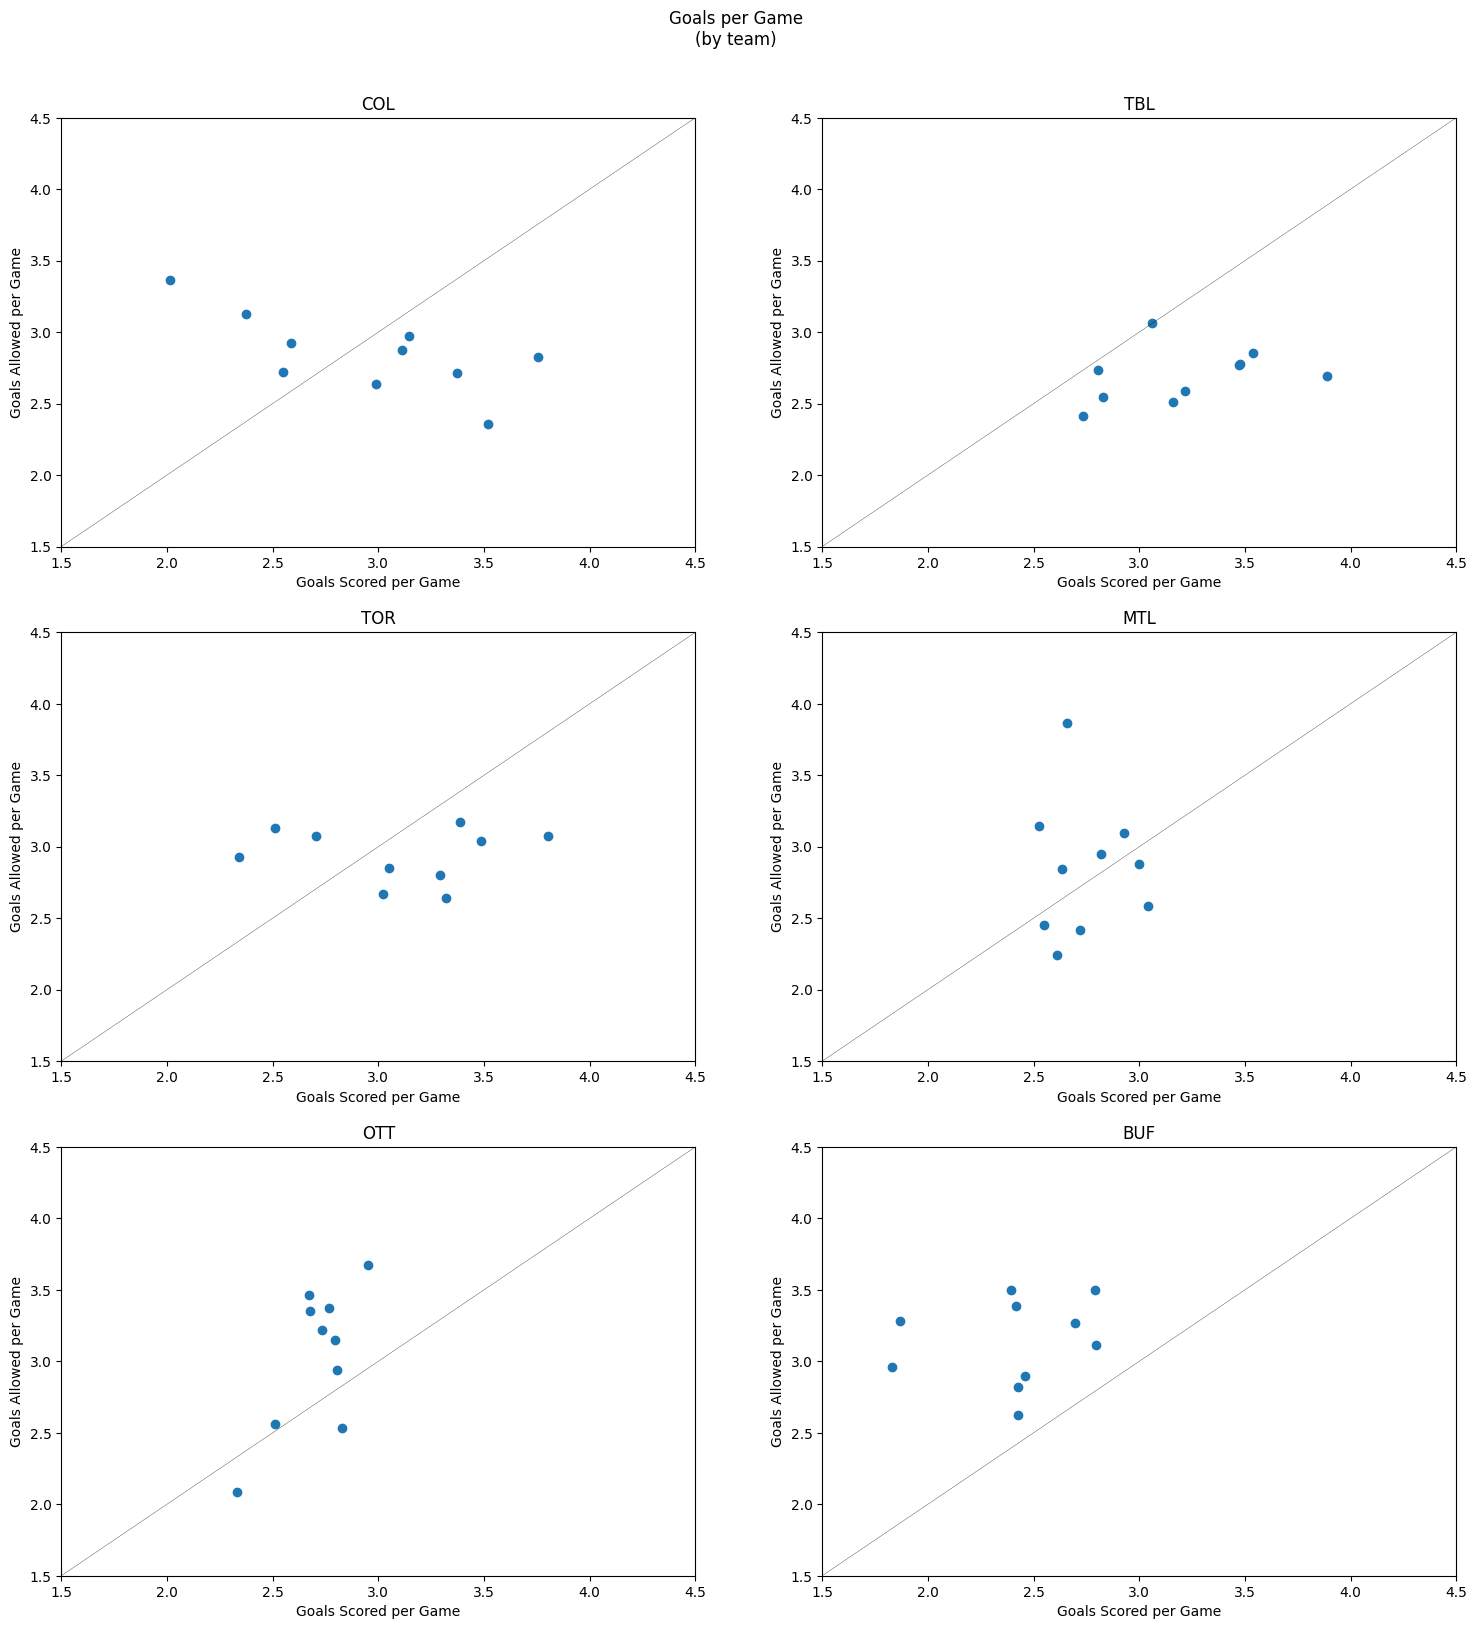

In [480]:
GoalScoredAndAllowed()